## Explore the parameters of the random forest and their impact on the results

This experiment is used to explore the parameters of the random forest and their impact on the results. The parameters that are explored are the 81 parameters of the input. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)

2023-07-20 12:00:59.539680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 12:00:59.628791: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 12:01:01.150667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/InputRelevance/../Library/splitData.py'>

In [2]:
# get the df from the pickle file
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_day3.pkl', 'rb') as f:
    df = pickle.load(f)

#### Training of the random forest with the data of all the mice

In [3]:
df_train, df_test = splitData.split_data_breeds(df)

In [4]:
df_train = df_train.drop(columns=['mouse'])
df_test = df_test.drop(columns=['mouse'])
df_train = df_train.drop(columns=['breed'])
df_test = df_test.drop(columns=['breed'])
# df_train = dataProcessing.rebalance_state(df_train, 13)
x_train, x_test, y_train, y_test, le = splitData.encode_scale_data(df_train, df_test, 13, cat_matrix=True)

In [5]:
rfc = RandomForestClassifier( random_state=13, n_jobs=-1, class_weight='balanced' )
rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=13)

In [22]:
y_pred = rfc.predict(x_test)

[[284031   1469  10497]
 [  8726  28406   5225]
 [ 15077   1163 469261]]
              precision    recall  f1-score   support

           n       0.92      0.96      0.94    295997
           r       0.92      0.67      0.77     42357
           w       0.97      0.97      0.97    485501

    accuracy                           0.95    823855
   macro avg       0.94      0.87      0.89    823855
weighted avg       0.95      0.95      0.95    823855



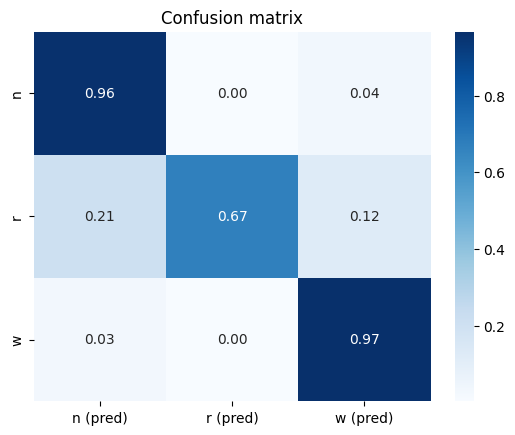

In [23]:
y = np.argmax(y_test, axis=1)
x = np.argmax(y_pred, axis=1)
cm = np.array(confusion_matrix(y, x))

print(cm)

cm = np.array(confusion_matrix(y, x, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')

print(classification_report(y, x, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix')
plt.show()


#### Display and select the most important parameters

First we display the importance of each parameters base on mean decrease in impurity. It's the sum over the number of splits that include the feature, proportionally to the number of samples it splits. 
(influenced by high cardinality)

In [24]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
feature_names = df_train.drop(columns=['state', 'rawState']).columns
forest_importances = pd.Series(importances, index=feature_names)

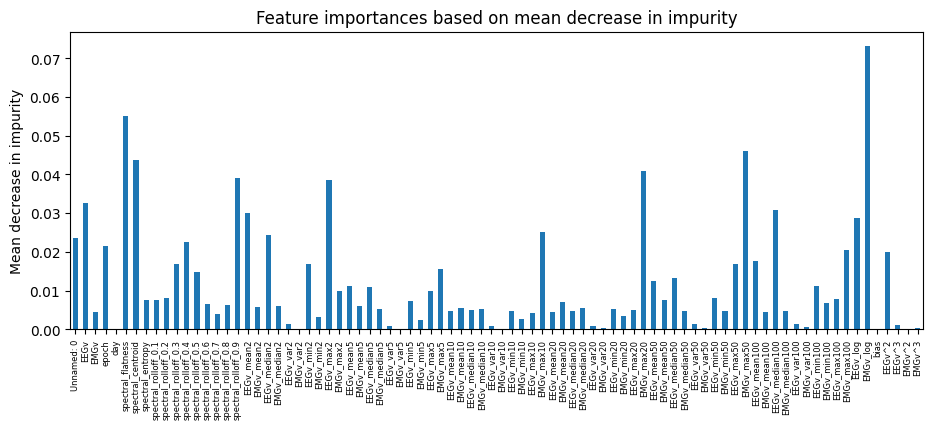

In [25]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances based on mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.xticks(fontsize=6)
fig.set_size_inches(10, 5)

In [26]:
# display the first 15 most important features in the order of importance
importance_impurity = forest_importances.sort_values(ascending=False)
type(importance_impurity)

pandas.core.series.Series

It's also possible to classify the parameters importance based on feature permutation. It measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. 

In [6]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/magali.egger/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-lear

OSError: [Errno 28] No space left on device

In [ ]:
# importance based on permutation importance
from sklearn.inspection import permutation_importance

result = permutation_importance(rfc, x_test, y_test, n_repeats=5, random_state=0, n_jobs=2)

NameError: name 'x_test' is not defined

In [ ]:
feature_names = df_train.drop(columns=['state', 'rawState']).columns
forest_importances = pd.Series(result.importances_mean, index=feature_names)

NameError: name 'result' is not defined

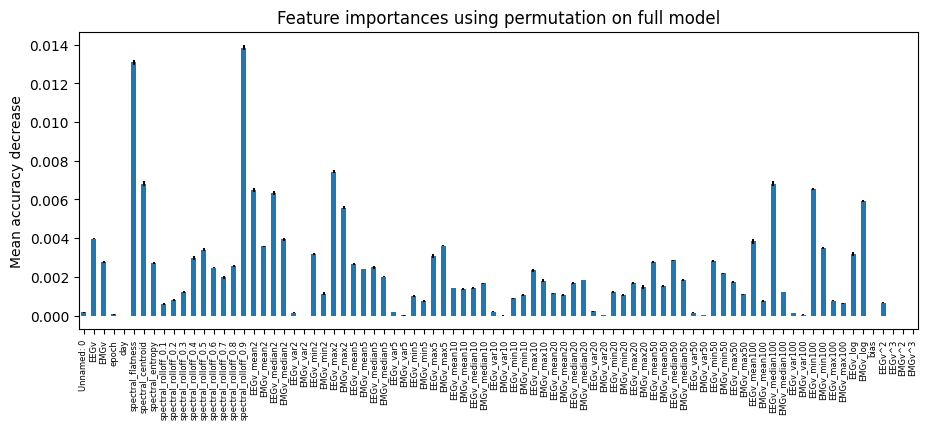

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances based permutation method")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.xticks(fontsize=6)
fig.set_size_inches(10, 5)
plt.show()

In [ ]:
# plot the 20 most important features
importance_permutation = forest_importances.sort_values(ascending=False)

spectral_rolloff_0.9    0.013838
spectral_flatness       0.013072
EEGv_max2               0.007435
EEGv_median100          0.006819
spectral_centroid       0.006818
EEGv_min100             0.006546
EEGv_mean2              0.006481
EEGv_median2            0.006325
EMGv_log                0.005938
EMGv_max2               0.005573
EEGv                    0.003975
EMGv_median2            0.003931
EEGv_mean100            0.003832
EMGv_max5               0.003614
EMGv_mean2              0.003568
EMGv_min100             0.003494
spectral_rolloff_0.5    0.003411
EEGv_log                0.003185
EEGv_min2               0.003170
EEGv_max5               0.003074
spectral_rolloff_0.4    0.002963
EEGv_median50           0.002851
EEGv_min50              0.002812
EMGv                    0.002768
EEGv_mean50             0.002764
spectral_entropy        0.002721
EEGv_mean5              0.002656
spectral_rolloff_0.8    0.002574
EEGv_median5            0.002487
spectral_rolloff_0.6    0.002465
EMGv_mean5

Based on the exploration of the parameters importance in this experiment, it's possible to select the most important parameters by setting a weighted classification threshold.

In [ ]:
# convert pandas series into list of tuples
importance_imp = list(importance_impurity.items())
importance_perm = list(importance_permutation.items())

In [ ]:

#importance_impurity = [('spectral_rolloff_0.9', 0.013838), ('spectral_flatness', 0.013072), ('EEGv_max2', 0.007435), ('EEGv_median100', 0.006819), ('spectral_centroid', 0.006818), ('EEGv_min100', 0.006546), ('EEGv_mean2', 0.006481), ('EEGv_median2', 0.006325), ('EMGv_log', 0.005938), ('EMGv_max2', 0.005573), ('EEGv', 0.003975), ('EMGv_median2', 0.003931), ('EEGv_mean100', 0.003832), ('EMGv_max5', 0.003614), ('EMGv_mean2', 0.003568), ('EMGv_min100', 0.003494), ('spectral_rolloff_0.5', 0.003411), ('EEGv_log', 0.003185), ('EEGv_min2', 0.003170), ('EEGv_max5', 0.003074)]
#importance_permutation = [('spectral_flatness', 0.057444), ('EMGv_log', 0.046666), ('spectral_rolloff_0.9', 0.046143), ('EEGv_max2', 0.043755), ('EMGv_max10', 0.042892), ('EMGv_max20', 0.040443), ('EMGv_max5', 0.033362), ('EEGv_mean2', 0.030696), ('spectral_centroid', 0.028809), ('EEGv', 0.028443), ('EEGv_median2', 0.026784), ('EMGv_max2', 0.021557), ('EEGv_min2', 0.021524), ('EEGv_log', 0.020389), ('EMGv_mean5', 0.019511), ('EEGv_median100', 0.019006), ('EMGv_mean20', 0.017116), ('EMGv_median2', 0.016909), ('EMGv_max50', 0.015643), ('spectral_rolloff_0.4', 0.015469)]


In [ ]:
# normalize the second values of the tuple in importance_impurity (the max values are 0.013838 and the min values are 0.003074)
importance_imp = [(x[0], (x[1]-0.003074)/(0.013838-0.003074)) for x in importance_impurity]
importance_perm = [(x[0], (x[1]-0.015469)/(0.057444-0.015469)) for x in importance_permutation]

In [ ]:
# for each tuple in importance impurity, compute the average with the corresponding tuple in importance_permutation
# if the feature is not in importance_permutation, the average is zero
importance = []
for x in importance_imp:
    for y in importance_perm:
        if x[0] == y[0]:
            importance.append((x[0], (x[1]+y[1])/2))
            break
    else:
        importance.append((x[0], 0))

importance.sort(key=lambda x: x[1], reverse=True)

In [ ]:
print(importance[:4])

[('spectral_flatness', 0.9644184318097362), ('spectral_rolloff_0.9', 0.8653841572364503), ('EEGv_max2', 0.5395120467514751), ('EMGv_log', 0.5046501020652301)]


The selected features based on importance are : 
- spectral flatness
- spectral roll-off 0.9
- EEGv_max 2
- EMGv log

We can now try to find a second selection based only on the EEG signals.

In [ ]:
print(importance)

[('spectral_flatness', 0.9644184318097362), ('spectral_rolloff_0.9', 0.8653841572364503), ('EEGv_max2', 0.5395120467514751), ('EMGv_log', 0.5046501020652301), ('EEGv_mean2', 0.3396407863858728), ('spectral_centroid', 0.332817153067302), ('EEGv_median2', 0.285795243403939), ('EMGv_max5', 0.23822238511934765), ('EEGv_median100', 0.2160917161721212), ('EEGv', 0.19639684285008885), ('EMGv_max2', 0.1886007391457064), ('EEGv_min2', 0.07658557444144105), ('EEGv_log', 0.06376238908996504), ('EMGv_median2', 0.05696168863232591), ('EEGv_min100', 0), ('EEGv_mean100', 0), ('EMGv_mean2', 0), ('EMGv_min100', 0), ('spectral_rolloff_0.5', 0), ('EEGv_max5', 0)]
